# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator. To do so, we simulate the system and record for the first 400 blocked cards, how much money the fraudsters are able to collect.

In [ ]:
from banksys import Transaction, Banksys
import polars as pl
from exceptions import InsufficientFundsError
from tqdm import tqdm

banksys = Banksys.load("/home/yann/projects/python/RL_Attack_September24/cache/banksys/20000-payers/910-days/start-2023-01-01/")
cards_blocked = set[int]()
transactions = dict[int, list[Transaction]]()

cards = set[int]()
terms = set[int]()
batch = list[Transaction]()
features = list[pl.DataFrame]()
trx = banksys.next_trx
pbar = tqdm(total=4000, desc="Processing transactions")
while len(cards_blocked) < 4_000:
    pbar.set_description(f"{trx.timestamp.date().isoformat()} - {len(cards_blocked)} blocked cards")
    if trx.is_fraud:
        if trx.card_id not in cards_blocked:
            # batch.append(trx)
            banksys.process_transactions(batch, update_balance=False)
            try:
                banksys.process_transaction(trx, update_balance=True)
            except InsufficientFundsError:
                trx.amount = 0.0
            finally:
                cards.clear()
                terms.clear()
                batch.clear()
            transactions[trx.card_id] = transactions.get(trx.card_id, []) + [trx]
            if trx.fraud_is_detected:
                pbar.update(1)
                cards_blocked.add(trx.card_id)
    elif trx.card_id in cards or trx.terminal_id in terms:
        banksys.process_transactions(batch, update_balance=False)
        cards.clear()
        terms.clear()
        batch.clear()
    cards.add(trx.card_id)
    terms.add(trx.terminal_id)
    batch.append(trx)
    trx = Transaction(**next(banksys.trx_iterator))


InsufficientFundsError: Card 17419 has insufficient funds for the action of amount 651.33.
Transaction(amount=651.33, timestamp=datetime.datetime(2023, 7, 5, 7, 58, 42), terminal_id=298, is_online=0, card_id=17419, is_fraud=0, predicted_label=np.True_)

## Score over training time

In [1]:
import numpy as np

logdirs = {
    "VAE": "logs/exp-final/vae",
    "PPO": "logs/exp-final/ppo",
    "R-PPO": "logs/exp-final/rppo",
}


def moving_average(data, window_size=200):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


logs/exp-final/vae
There are 4 runs in VAE
logs/exp-final/ppo
There are 4 runs in PPO
logs/exp-final/rppo
There are 4 runs in R-PPO


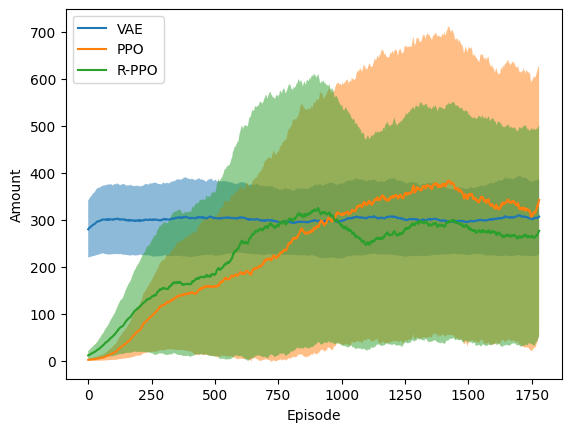

In [3]:
import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time
    mean, std = exp.mean_std_amounts_over_time
    mean = moving_average(mean)[:-20]
    std = moving_average(std)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Amount")
plt.legend()
plt.savefig("amount-over-time.svg")


## Number of transactions per card over time

There are 4 runs in VAE
There are 4 runs in PPO
There are 4 runs in R-PPO


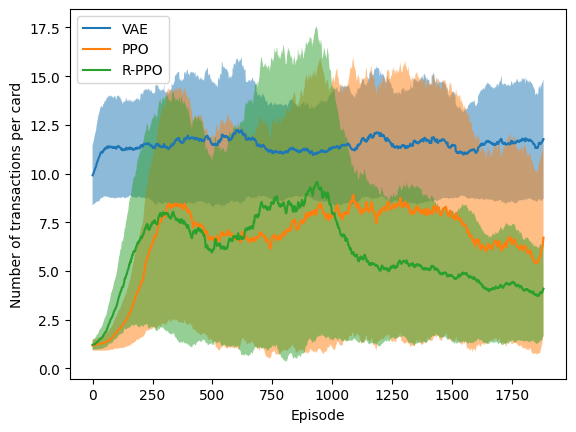

In [4]:
import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=100)[:-20]
    std = moving_average(std, window_size=100)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

In [5]:
experiment = Experiment.load(logdir)
label, max(experiment.n_transactions_over_time[0])

('R-PPO', np.int64(44))

## Total amount collected

C:\Users\dalun\AppData\Local\Temp\ipykernel_2404\2183109214.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(amounts, labels=labels, showmeans=True)


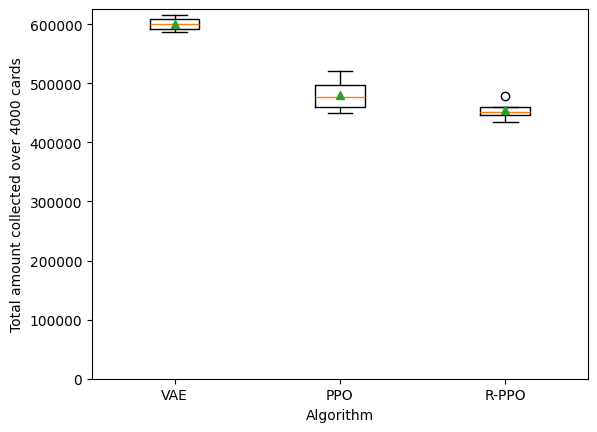

In [6]:
import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.total_amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
plt.ylim(bottom=0)  # Set lower y-axis limit to 0
plt.savefig("boxplot-amounts.svg")
plt.show()


In [7]:
# Plot amounts boxplots


import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.amounts_over_time))
    print(amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.ylim(bottom=0)  # Set lower y-axis limit to 0
plt.savefig("boxplot-amounts.svg")
plt.show()


SyntaxError: unmatched ')' (2278551692.py, line 11)

In [11]:
exp.get_actions

AttributeError: 'Experiment' object has no attribute 'get_actions'

In [111]:
exp.amounts_over_time[0]

array([   0.        ,    0.        ,    0.        , ...,  629.94995117,
       1050.18994141,  761.51000977], shape=(2000,))